# Initialize Notebook
<hr style="border: none; height: 5px; background-color: white; margin-top: 0px; margin-bottom: 0px;">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import ROOT
import uproot
import os
import sys
import tqdm
import pandas as pd

%jsroot on
# %matplotlib qt
%matplotlib inline

Welcome to JupyROOT 6.30/00


In [2]:
sys.path.append("../")
import plotParameters

# Load Hit Data
<hr style="border: none; height: 5px; background-color: white; margin-top: 0px; margin-bottom: 0px;">

In [3]:
# file_input_name = '../runs/calibration/calibration_-0.85000_-0.85000_-0.85000.root'
# file_input_name = '../runs/calibration/calibration_-0.85000_-0.85000_-0.85000.root'
file_input_name = '../runs/calibration/calibration.root'
# file_input_name = '../runs/output_NEST_e-_1MeV.root'
# file_input_name = '../build/event_total.root'
# file_input_name = '../build/event.root'
histogram_directory = 'photoSensor_hits_histograms'
file_input_pyroot = ROOT.TFile(file_input_name)
file_input_uproot = uproot.open(file_input_name)

histogram_names = [name for name in file_input_uproot.keys() if "/photoSensor_" in name]
print(histogram_names)

histogram_titles = [file_input_pyroot.Get(name).GetTitle() for name in histogram_names]
print(histogram_titles)

histogram_positions = [(float(title.split('_')[2]), float(title.split('_')[3]), float(title.split('_')[4])) for title in histogram_titles]
print(histogram_positions)

tree_names = [name for name in file_input_uproot.keys() if histogram_directory not in name]
print(tree_names)

['photoSensor_hits_histograms/photoSensor_0;1', 'photoSensor_hits_histograms/photoSensor_1;1', 'photoSensor_hits_histograms/photoSensor_2;1', 'photoSensor_hits_histograms/photoSensor_3;1', 'photoSensor_hits_histograms/photoSensor_4;1', 'photoSensor_hits_histograms/photoSensor_5;1', 'photoSensor_hits_histograms/photoSensor_6;1', 'photoSensor_hits_histograms/photoSensor_7;1', 'photoSensor_hits_histograms/photoSensor_8;1', 'photoSensor_hits_histograms/photoSensor_9;1', 'photoSensor_hits_histograms/photoSensor_10;1', 'photoSensor_hits_histograms/photoSensor_11;1', 'photoSensor_hits_histograms/photoSensor_12;1', 'photoSensor_hits_histograms/photoSensor_13;1', 'photoSensor_hits_histograms/photoSensor_14;1', 'photoSensor_hits_histograms/photoSensor_15;1', 'photoSensor_hits_histograms/photoSensor_16;1', 'photoSensor_hits_histograms/photoSensor_17;1', 'photoSensor_hits_histograms/photoSensor_18;1', 'photoSensor_hits_histograms/photoSensor_19;1', 'photoSensor_hits_histograms/photoSensor_20;1', '

In [4]:
tree = file_input_uproot['photoSensor_hits;1']

position_relative_x = tree['photoSensor_hits_position_relative_x'].array()
position_relative_y = tree['photoSensor_hits_position_relative_y'].array()

histogram = file_input_pyroot.Get(histogram_names[0])
n_bins_x = histogram.GetNbinsX()
n_bins_y = histogram.GetNbinsY()
values = np.zeros((n_bins_x, n_bins_y))
x_edges = []
y_edges = []
for i in range(1, n_bins_x + 2):
    x_edges.append(histogram.GetXaxis().GetBinLowEdge(i))
for i in range(1, n_bins_y + 2):
    y_edges.append(histogram.GetYaxis().GetBinLowEdge(i))
x_edges[ 0] -= 1e-9
y_edges[ 0] -= 1e-9
x_edges[-1] += 1e-9
y_edges[-1] += 1e-9

position_relative_x_bins = pd.Series(pd.cut(np.array(position_relative_x), bins=x_edges, retbins=False))
position_relative_y_bins = pd.Series(pd.cut(np.array(position_relative_y), bins=y_edges, retbins=False))
position_relative_x_binned = position_relative_x_bins.apply(lambda x: (x.right + x.left) / 2)
position_relative_y_binned = position_relative_y_bins.apply(lambda x: (x.right + x.left) / 2)
position_relative_x_nBin = position_relative_x_bins.cat.codes
position_relative_y_nBin = position_relative_y_bins.cat.codes

position_initial_x = tree['photoSensor_hits_position_initial_x'].array()
position_initial_y = tree['photoSensor_hits_position_initial_y'].array()
position_initial_z = tree['photoSensor_hits_position_initial_z'].array()

time = tree['photoSensor_hits_time'].array()
photoSensorID = tree['photoSensor_hits_photoSensorID'].array()
photoSensorPosition = [(float(ID.split('_')[2]), float(ID.split('_')[3]), float(ID.split('_')[4])) for ID in photoSensorID]
photoSensorWall = [ID.split('_')[1] for ID in photoSensorID]
photoSensorDirection = []
for wall in photoSensorWall:
    if wall == '+x':
        photoSensorDirection.append([-1, 0, 0])
    elif wall == '-x':
        photoSensorDirection.append([+1, 0, 0])
    elif wall == '+y':
        photoSensorDirection.append([0, -1, 0])
    elif wall == '-y':
        photoSensorDirection.append([0, +1, 0])
    elif wall == '+z':
        photoSensorDirection.append([0, 0, -1])
    elif wall == '-z':
        photoSensorDirection.append([0, 0, +1])

df_hits = pd.DataFrame(columns=['sensor_name', 'sensor_direction', 'sensor_position', 'relativePosition', 'relativePosition_binned', 'time'])
df_hits['sensor_name'] = photoSensorID
df_hits['sensor_direction'] = photoSensorDirection
df_hits['sensor_position'] = photoSensorPosition
df_hits['relativePosition'] = list(zip(position_relative_x, position_relative_y))
df_hits['relativePosition_binned'] = list(zip(position_relative_x_binned, position_relative_y_binned))
df_hits['relativePosition_nBin'] = list(zip(position_relative_x_nBin, position_relative_y_nBin))
df_hits['initialPosition'] = list(zip(position_initial_x, position_initial_y, position_initial_z))
df_hits['time'] = time

# print(df_hits)

# Load All Data
<hr style="border: none; height: 5px; background-color: white; margin-top: 0px; margin-bottom: 0px;">

In [5]:
# Load the trees from the root file
tree_library = {}
tree_branch_library = {}
branch_data = {}
for name in tqdm.tqdm(tree_names):
    tree_library[name] = file_input_uproot[name]
    tree_branch_library[name] = tree_library[name].keys()
    print(name, tree_branch_library[name])
    for key in tree_branch_library[name]:
        branch_data[key] = tree_library[name][key].array()

  0%|          | 0/3 [00:00<?, ?it/s]

photoSensor_hits;1 ['photoSensor_hits_position_absolute_x', 'photoSensor_hits_position_absolute_y', 'photoSensor_hits_position_absolute_z', 'photoSensor_hits_position_relative_x', 'photoSensor_hits_position_relative_y', 'photoSensor_hits_position_relative_z', 'photoSensor_hits_position_initial_x', 'photoSensor_hits_position_initial_y', 'photoSensor_hits_position_initial_z', 'photoSensor_hits_time', 'photoSensor_hits_process', 'photoSensor_hits_photoSensorID', 'photoSensor_hits_energy']


 33%|███▎      | 1/3 [00:00<00:01,  1.06it/s]

primary;1 ['primary_position_x', 'primary_position_y', 'primary_position_z', 'primary_direction_x', 'primary_direction_y', 'primary_direction_z', 'primary_process', 'primary_time', 'primary_energy', 'primary_volume', 'primary_pdg']
photon;1 ['photon_length', 'photon_process', 'photon_time', 'photon_position_x', 'photon_position_y', 'photon_position_z', 'photon_direction_x', 'photon_direction_y', 'photon_direction_z', 'photon_energy', 'photon_volume']


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


In [6]:
# Extract the data for photon_process and photon_volume
photon_process = branch_data['photon_process']
photon_volume = branch_data['photon_volume']

# Make a list of the unique photon_process and photon_volume values
unique_photon_process = np.unique(photon_process)
unique_photon_volume = np.unique(photon_volume)

# Make a dictionary to store the number of photons in each process and volume
photon_process_count = {}
photon_volume_count = {}

# # Loop over the unique photon_process values
# for process in tqdm.tqdm(unique_photon_process):
#     # Get the indices for the current process
#     indices = np.where(photon_process == process)
#     # Store the number of photons in the current process
#     photon_process_count[process] = len(indices[0])

for process in tqdm.tqdm(photon_process):
    if process in photon_process_count:
        photon_process_count[process] += 1
    else:
        photon_process_count[process] = 1

# # Loop over the unique photon_volume values
# for volume in tqdm.tqdm(unique_photon_volume):
#     # Get the indices for the current volume
#     indices = np.where(photon_volume == volume)
#     # Store the number of photons in the current volume
#     photon_volume_count[volume] = len(indices[0])

for volume in tqdm.tqdm(photon_volume):
    if volume in photon_volume_count:
        photon_volume_count[volume] += 1
    else:
        photon_volume_count[volume] = 1

# Print the photon_process_count and photon_volume_count dictionaries
print(photon_process_count)
print(photon_volume_count)

# Combine individualy named volumes into more general volumes
photon_volume_general_count = {}
for volume in tqdm.tqdm(photon_volume_count):
    if 'lensSystem_lens' in volume:
        photon_volume_general_count['lensSystem_lens'] = photon_volume_general_count.get('lensSystem_lens', 0) + photon_volume_count[volume]
    elif 'photoSensor_surface' in volume:
        photon_volume_general_count['photoSensor_surface'] = photon_volume_general_count.get('photoSensor_surface', 0) + photon_volume_count[volume]
    elif 'photoSensor_body' in volume:
        photon_volume_general_count['phototSensor_body'] = photon_volume_general_count.get('phototSensor_body', 0) + photon_volume_count[volume]
    # elif 'calorimeter_horizontal' in volume:
    #     photon_volume_general_count['calorimeter_horizontal'] = photon_volume_general_count.get('calorimeter_horizontal', 0) + photon_volume_count[volume]
    # elif 'calorimeter_vertical' in volume:
    #     photon_volume_general_count['calorimeter_vertical'] = photon_volume_general_count.get('calorimeter_vertical', 0) + photon_volume_count[volume]
    # elif 'calorimeter_middle' in volume:
    #     photon_volume_general_count['calorimeter_middle'] = photon_volume_general_count.get('calorimeter_middle', 0) + photon_volume_count[volume]
    elif 'calorimeter' in volume:
        photon_volume_general_count['calorimeter'] = photon_volume_general_count.get('calorimeter', 0) + photon_volume_count[volume]
    else:
        photon_volume_general_count[volume] = photon_volume_general_count.get(volume, 0) + photon_volume_count[volume]

# Print the photon_volume_general_count dictionary
print(photon_volume_general_count)

100%|██████████| 1053876/1053876 [00:06<00:00, 154738.91it/s]


{'OpAbsorption': 683774, 'Transportation': 370094, 'OpRayleigh': 8}
{'detector_medium': 779908, '/DSPD_+x_1114.704220_-550.000000_330.000000_67_lensSystem_lens_1_preTrim': 64, '/calorimeter_vertical_G4Box': 69544, '/DSPD_-z_-770.000000_330.000000_-1114.704220_16_lensSystem_lens_1_preTrim': 209, '/DSPD_-y_-330.000000_-1114.704220_-550.000000_67_lensSystem_lens_1_preTrim': 207, '/DSPD_-y_-330.000000_-1114.704220_-550.000000_67_lensSystem_lens_0_lens': 52, '/calorimeter_horizontal_G4Box': 69834, '/DSPD_-z_550.000000_-770.000000_-1114.704220_71_lensSystem_lens_1_preTrim': 201, '/DSPD_-y_-110.000000_-1114.704220_-110.000000_55_lensSystem_lens_1_preTrim': 198, '/DSPD_+x_1114.704220_-330.000000_-110.000000_46_lensSystem_lens_1_preTrim': 42, '/DSPD_+y_-330.000000_1114.704220_-550.000000_62_lensSystem_lens_1_preTrim': 218, '/DSPD_+y_-110.000000_1114.704220_-110.000000_54_lensSystem_lens_1_preTrim': 231, '/DSPD_+z_-110.000000_110.000000_1114.704220_54_lensSystem_lens_1_preTrim': 213, '/DSPD_+z_-

100%|██████████| 2322/2322 [00:00<00:00, 3895669.56it/s]


{'detector_medium': 779908, 'lensSystem_lens': 118090, 'calorimeter': 140662, 'photoSensor_surface': 7672, 'phototSensor_body': 7544}


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_20747/1854754086.py:21: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
  fig.show()


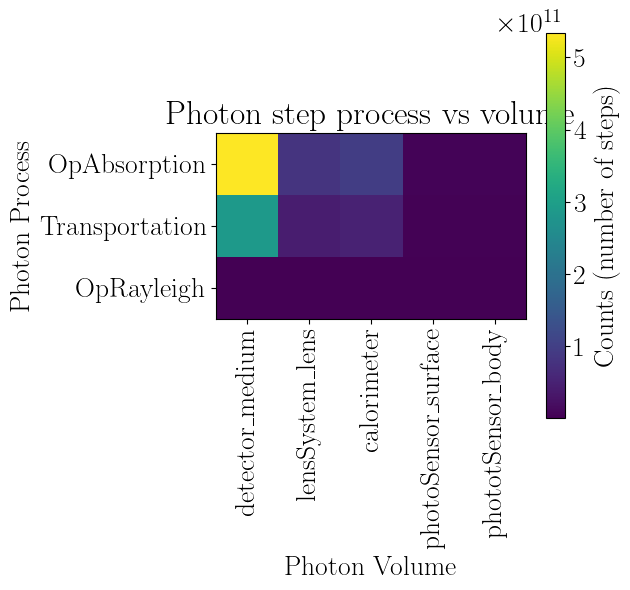

In [7]:
threshold = 0

non_zero_photon_volume = {k: v for k, v in photon_volume_general_count.items() if v >= threshold}
non_zero_photon_process = {k: v for k, v in photon_process_count.items() if v >= threshold}

photon_volume_general_count_values = list(non_zero_photon_volume.values())
photon_process_count_values = list(non_zero_photon_process.values())

convolution_matrix = np.outer(photon_process_count_values, photon_volume_general_count_values)

fig, ax = plt.subplots()
im = ax.imshow(convolution_matrix, cmap='viridis')
fig.colorbar(im, ax=ax, label='Counts (number of steps)')
ax.set_xlabel("Photon Volume")
ax.set_ylabel("Photon Process")
ax.set_title("Photon step process vs volume")
ax.set_yticks(range(len(non_zero_photon_process)))
ax.set_yticklabels(non_zero_photon_process.keys())
ax.set_xticks(range(len(non_zero_photon_volume)))
ax.set_xticklabels(non_zero_photon_volume.keys(), rotation=90)
fig.show()